In [ ]:
# pip install pydub --upgrade

%pip install numpy
%pip install librosa
%pip install pandas
%pip install matplotlib
%pip install wave
%pip install noisereduce
%pip install pydub

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd

import wave
import librosa
import noisereduce as nr
from scipy.io import wavfile
from pydub import AudioSegment

import matplotlib.pyplot as plt

c:\Users\Adisaputra Zidha\AppData\Local\Programs\Python\Python39\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# Cek kembali apakah jumlah data sesuai dengan jumlah di awal
def count_files(datasetFolders):
    paths = ['abnormal', 'normal']
    for path in paths:
        folder_path = os.path.join(datasetFolders, path)
        num_files = sum(1 for item in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, item)))
        print(f"Jumlah file di folder '{path}': {num_files}")

## Start Here

In [40]:
# Path ke folder utama dan target
main_folder = './heart-sound-recordings'
main_target_folder = './1_preprocessData'
os.makedirs(main_target_folder, exist_ok=True)

targets = ['abnormal', 'normal']
for target in targets:
    os.makedirs(os.path.join(main_target_folder, target), exist_ok=True)

# Daftar folder training
training_folders = ['training-a', 'training-b', 'training-c', 'training-d', 'training-e', 'training-f']

In [41]:
# Fungsi untuk membaca kategori dari file REFERENCE.csv di setiap folder
def read_data_labels(folder_path):
    reference_path = os.path.join(folder_path, 'REFERENCE.csv')
    if os.path.exists(reference_path):
        with open(reference_path, 'r') as file:
            lines = file.readlines()
            reference_dict = {}
            for line in lines:
                file_name, label = line.strip().split(',')
                reference_dict[file_name] = label
        return reference_dict
    else:
        return {}

# Fungsi untuk memindahkan file .wav sesuai dengan kategori
def copy_wav_files(folder_path, target_folder):
    reference_dict = read_data_labels(folder_path)
    wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    for wav_file in wav_files:
        wav_file_name, _ = os.path.splitext(wav_file)
        label = reference_dict.get(wav_file_name, None)
        
        if label is not None:
            label_folder = 'abnormal' if label == -1 else 'normal'
            source_file_path = os.path.join(folder_path, wav_file)
            target_label_folder = os.path.join(target_folder, label_folder)
            
            if not os.path.exists(target_label_folder):
                os.makedirs(target_label_folder)
                
            target_file_path = os.path.join(target_label_folder, wav_file)
            if not os.path.exists(target_file_path):
                shutil.copy(source_file_path, target_file_path)
                
            else:
                print(f"File {wav_file} already exists in target folder. Skipping...")

# Loop melalui setiap folder dan pindahkan file .wav
for folder_name in training_folders:
    folder_path = os.path.join(main_folder, folder_name)
    copy_wav_files(folder_path, main_target_folder)
    
print('Proses pengelompokkan data selesai.')

Proses pengelompokkan data selesai.


In [42]:
# Fungsi untuk menggabungkan semua file CSV di setiap folder training menjadi satu
def merge_csv_files(training_folders, main_folder):
    dfs = []
    for folder_name in training_folders:
        folder_path = os.path.join(main_folder, folder_name)
        csv_path = os.path.join(folder_path, 'REFERENCE.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path, header=None, names=['file', 'label'])
            dfs.append(df)
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

# Gabungkan semua file CSV
merged_csv = merge_csv_files(training_folders, main_folder)
merged_csv_path = os.path.join(main_target_folder, 'allLabel.csv')
merged_csv.to_csv(merged_csv_path, index=False)
print("Proses penggabungan file CSV selesai.")

Proses penggabungan file CSV selesai.


In [10]:
count_files('./1_preprocessData')

Jumlah file di folder 'abnormal': 2575
Jumlah file di folder 'normal': 665


## Segmentasi Data

In [4]:
def segment_audio(folder_path, output_folder):
    # Membuat folder output jika belum ada
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for label in os.listdir(folder_path):  # Loop melalui abnormal dan normal
        label_folder_path = os.path.join(folder_path, label)
        output_label_folder_path = os.path.join(output_folder, label)
        
        # Membuat folder output untuk setiap label jika belum ada, kecuali jika itu adalah file .csv
        if os.path.isdir(label_folder_path) and not label.endswith('.csv'):
            if not os.path.exists(output_label_folder_path):
                os.makedirs(output_label_folder_path)
        
            for wav_file in os.listdir(label_folder_path):
                if wav_file.endswith('.wav'):
                    wav_file_path = os.path.join(label_folder_path, wav_file)
                    
                    # Baca durasi file
                    with wave.open(wav_file_path, 'r') as wf:
                        frames = wf.getnframes()
                        rate = wf.getframerate()
                        duration = frames / float(rate)
                    
                    # Jika durasi >= 15 detik, potong 15 detik pertama
                    if duration >= 15:
                        audio = AudioSegment.from_wav(wav_file_path)
                        fifteen_seconds_audio = audio[:15000]  # 15 detik pertama
                        output_file_path = os.path.join(output_label_folder_path, wav_file)
                        fifteen_seconds_audio.export(output_file_path, format="wav")

# Misalkan folder input dan output Anda adalah sebagai berikut:
input_folder = "./1_preprocessData"
output_folder = "./2_segmentedData"

# Melakukan segmentasi data
segment_audio(input_folder, output_folder)
print('Proses Segmentasi Data Selesai.')

Proses Segmentasi Data Selesai.


In [3]:
count_files('./2_segmentedData')

Jumlah file di folder 'abnormal': 1783
Jumlah file di folder 'normal': 491


In [13]:
def calculate_duration_stats(segmented_folder):
    duration_stats = {'Label': [], 'File': [], 'Duration': []}

    for label in os.listdir(segmented_folder):
        label_folder_path = os.path.join(segmented_folder, label)
        if os.path.isdir(label_folder_path):
            for filename in os.listdir(label_folder_path):
                if filename.endswith('.wav'):
                    filepath = os.path.join(label_folder_path, filename)
                    try:
                        audio, sr = librosa.load(filepath, sr=None)
                        duration = librosa.get_duration(y=audio, sr=sr)
                        duration_stats['Label'].append(label)
                        duration_stats['File'].append(filename)
                        duration_stats['Duration'].append(duration)
                    except Exception as e:
                        print(f"Error processing {filename}: {e}")
    
    return pd.DataFrame(duration_stats)

# Misalkan folder yang ingin Anda periksa adalah 'segmentedData'
segmented_folder = "./2_segmentedData"
duration_stats_df = calculate_duration_stats(segmented_folder)

# Menampilkan nilai maksimal dan minimal durasi untuk setiap kelas (normal dan abnormal)
class_stats = duration_stats_df.groupby('Label')['Duration'].agg(['min', 'max'])
print(class_stats)

           min   max
Label               
abnormal  15.0  15.0
normal    15.0  15.0


## Denoising

In [5]:
def denoising_audio(folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for label in ['normal', 'abnormal']:
        label_folder_path = os.path.join(folder_path, label)
        output_label_folder_path = os.path.join(output_folder, label)
        if not os.path.exists(output_label_folder_path):
            os.makedirs(output_label_folder_path)
        
        for wav_file in os.listdir(label_folder_path):
            if wav_file.endswith('.wav'):
                wav_file_path = os.path.join(label_folder_path, wav_file)
                output_file_path = os.path.join(output_label_folder_path, wav_file)
                try:
                    # Memuat audio
                    rate, data = wavfile.read(wav_file_path)
                    # Proses denoising
                    reduced_noise = nr.reduce_noise(y=data, sr=rate, time_mask_smooth_ms=128)
                    # Menyimpan audio yang sudah diproses
                    wavfile.write(output_file_path, rate, reduced_noise)
                except Exception as e:
                    print(f"Error processing {wav_file}: {e}")

input_folder = "./2_segmentedData"
output_folder = "./3_denoisedData"

# Melakukan proses denoising
denoising_audio(input_folder, output_folder)
print('Proses Denoising Data Selesai.')

Proses Denoising Data Selesai.


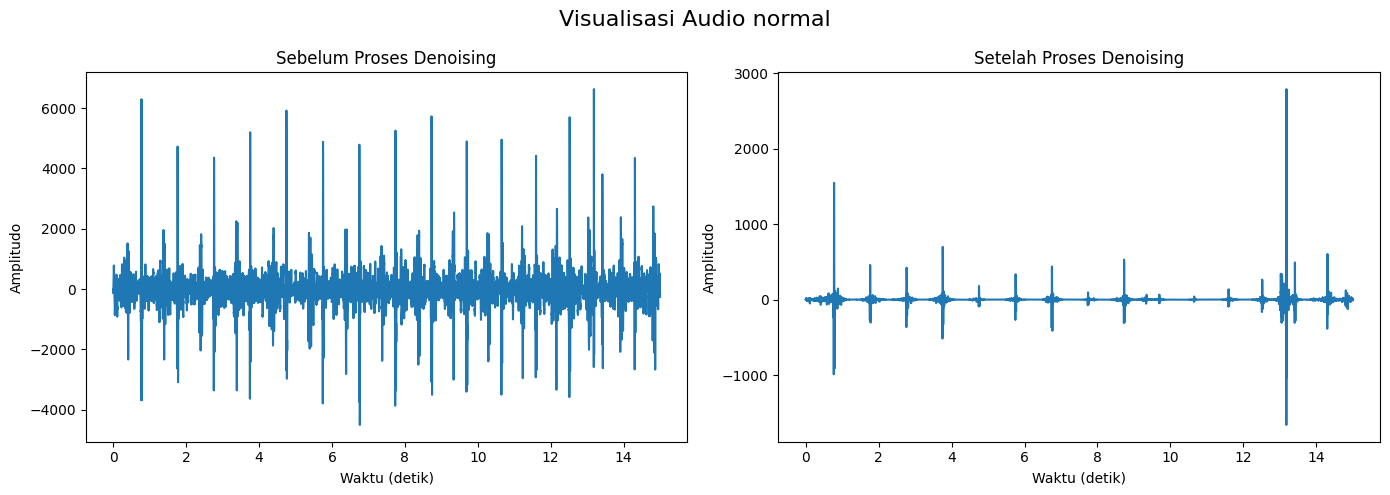

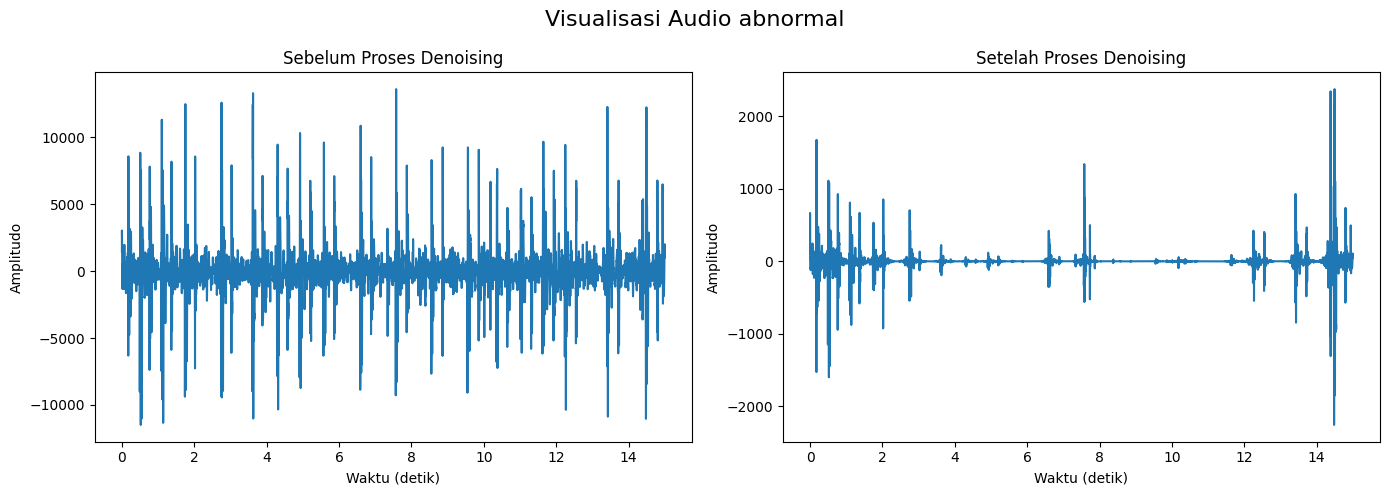

In [15]:
# Display untuk menampilkan proses denoising sinyal suara jantung
def visualize_denoising_audio(input_folder, output_folder, label):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(f'Visualisasi Audio {label}', fontsize=16)
    
    # Plot data sebelum dan sesudah proses denoising
    rate, data = wavfile.read(os.path.join(input_folder, label, os.listdir(os.path.join(input_folder, label))[0]))
    time = len(data) / rate  # Hitung durasi dalam detik
    time_axis = np.linspace(0, time, len(data))  # Buat sumbu x dalam detik
    axes[0].plot(time_axis, data)
    axes[0].set_title('Sebelum Proses Denoising')
    axes[0].set_xlabel('Waktu (detik)')
    axes[0].set_ylabel('Amplitudo')

    rate, data = wavfile.read(os.path.join(output_folder, label, os.listdir(os.path.join(output_folder, label))[0]))
    time = len(data) / rate  # Hitung durasi dalam detik
    time_axis = np.linspace(0, time, len(data))  # Buat sumbu x dalam detik
    axes[1].plot(time_axis, data)
    axes[1].set_title('Setelah Proses Denoising')
    axes[1].set_xlabel('Waktu (detik)')
    axes[1].set_ylabel('Amplitudo')

    plt.tight_layout()
    plt.show()

input_folder = "./2_segmentedData"
output_folder = "./3_denoisedData"

for label in ['normal', 'abnormal']:
    visualize_denoising_audio(input_folder, output_folder, label)

## Normalization Data

In [20]:
def normalized_audio(folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for label in ['normal', 'abnormal']:
        label_folder_path = os.path.join(folder_path, label)
        output_label_folder_path = os.path.join(output_folder, label)
        if not os.path.exists(output_label_folder_path):
            os.makedirs(output_label_folder_path)
        
        for wav_file in os.listdir(label_folder_path):
            if wav_file.endswith('.wav'):
                wav_file_path = os.path.join(label_folder_path, wav_file)
                output_file_path = os.path.join(output_label_folder_path, wav_file)
                try:
                    # Membaca file audio
                    rate, data = wavfile.read(wav_file_path)
                    # Normalisasi data
                    max_val = np.max(np.abs(data))
                    normalized_data = data / max_val
                    # Menyimpan data yang sudah dinormalisasi
                    wavfile.write(output_file_path, rate, normalized_data)
                except Exception as e:
                    print(f"Error processing {wav_file}: {e}")

input_folder = "./3_denoisedData"
output_folder = "./4_normalizedData"

# Melakukan proses normalisasi
normalized_audio(input_folder, output_folder)
print('Proses Normalized Data Selesai.')


Proses Normalized Data Selesai.


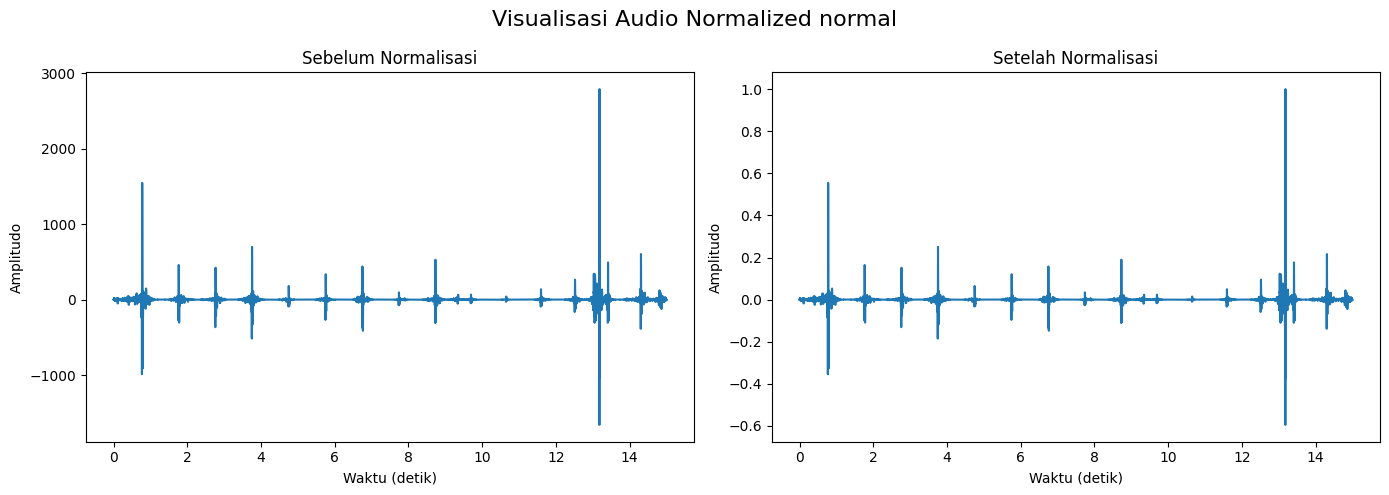

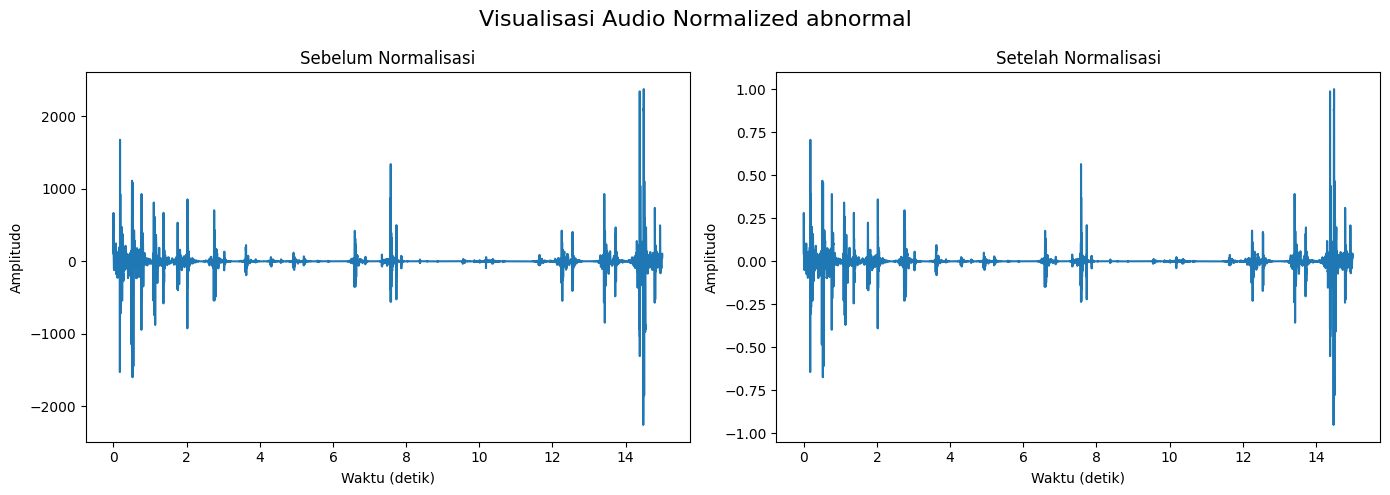

In [21]:
# Mendefinisikan fungsi untuk memplot perbandingan gelombang suara
def visualize_normalized_audio(input_folder, output_folder, label):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(f'Visualisasi Audio Normalized {label}', fontsize=16)
    
    # Plot data sebelum dan sesudah proses normalisasi
    rate, data = wavfile.read(os.path.join(input_folder, label, os.listdir(os.path.join(input_folder, label))[0]))
    time = len(data) / rate  # Hitung durasi dalam detik
    time_axis = np.linspace(0, time, len(data))  # Buat sumbu x dalam detik
    axes[0].plot(time_axis, data)
    axes[0].set_title('Sebelum Normalisasi')
    axes[0].set_xlabel('Waktu (detik)')
    axes[0].set_ylabel('Amplitudo')

    rate, data = wavfile.read(os.path.join(output_folder, label, os.listdir(os.path.join(output_folder, label))[0]))
    time = len(data) / rate  # Hitung durasi dalam detik
    time_axis = np.linspace(0, time, len(data))  # Buat sumbu x dalam detik
    axes[1].plot(time_axis, data)
    axes[1].set_title('Setelah Normalisasi')
    axes[1].set_xlabel('Waktu (detik)')
    axes[1].set_ylabel('Amplitudo')

    plt.tight_layout()
    plt.show()

input_folder = "./3_denoisedData"
output_folder = "./4_normalizedData"

for label in ['normal', 'abnormal']:
    visualize_normalized_audio(input_folder, output_folder, label)

## Fast Fourier Transform (FFT)

In [6]:
def fft_audio(folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for label in ['normal', 'abnormal']:
        label_folder_path = os.path.join(folder_path, label)
        output_label_folder_path = os.path.join(output_folder, label)
        if not os.path.exists(output_label_folder_path):
            os.makedirs(output_label_folder_path)
        
        for wav_file in os.listdir(label_folder_path):
            if wav_file.endswith('.wav'):
                wav_file_path = os.path.join(label_folder_path, wav_file)
                output_file_path = os.path.join(output_label_folder_path, wav_file.replace('.wav', '.npy'))
                try:
                    # Membaca file audio
                    rate, data = wavfile.read(wav_file_path)
                    # Menerapkan FFT pada data audio
                    fft_data = np.abs(np.fft.fft(data))
                    # Menyimpan data FFT
                    np.save(output_file_path, fft_data)
                    # print(f"Processed {wav_file}")
                except Exception as e:
                    print(f"Error processing {wav_file}: {e}")

# Misalkan folder input dan output Anda adalah sebagai berikut:
input_folder = "./4_normalizedData"
output_folder = "./5_fftData"

# Melakukan proses FFT
fft_audio(input_folder, output_folder)
print('Proses FFT Data Selesai.')

Proses FFT Data Selesai.


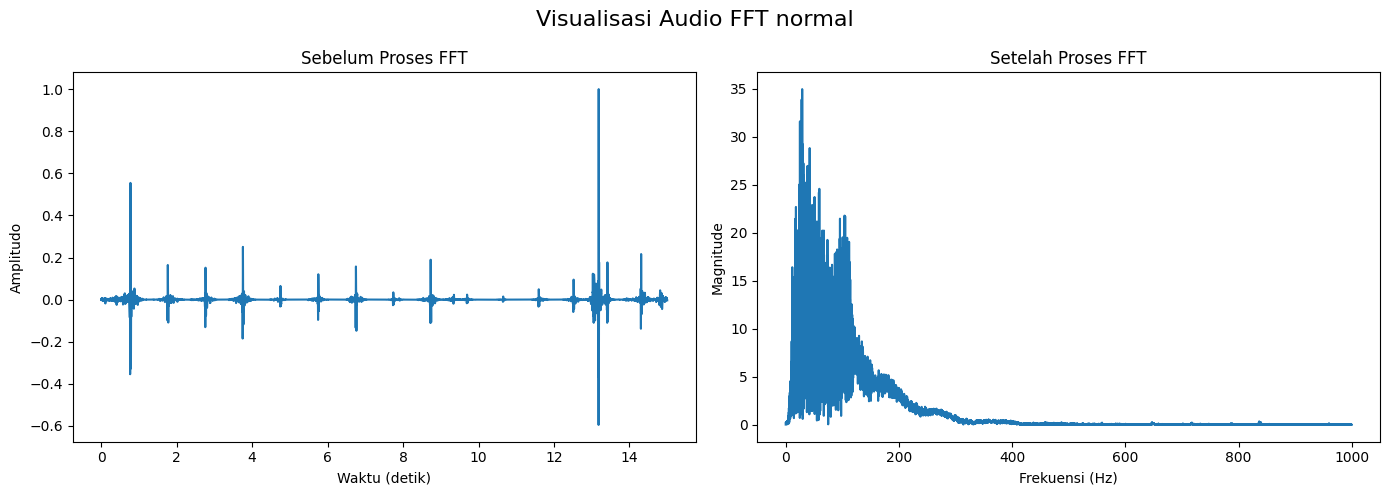

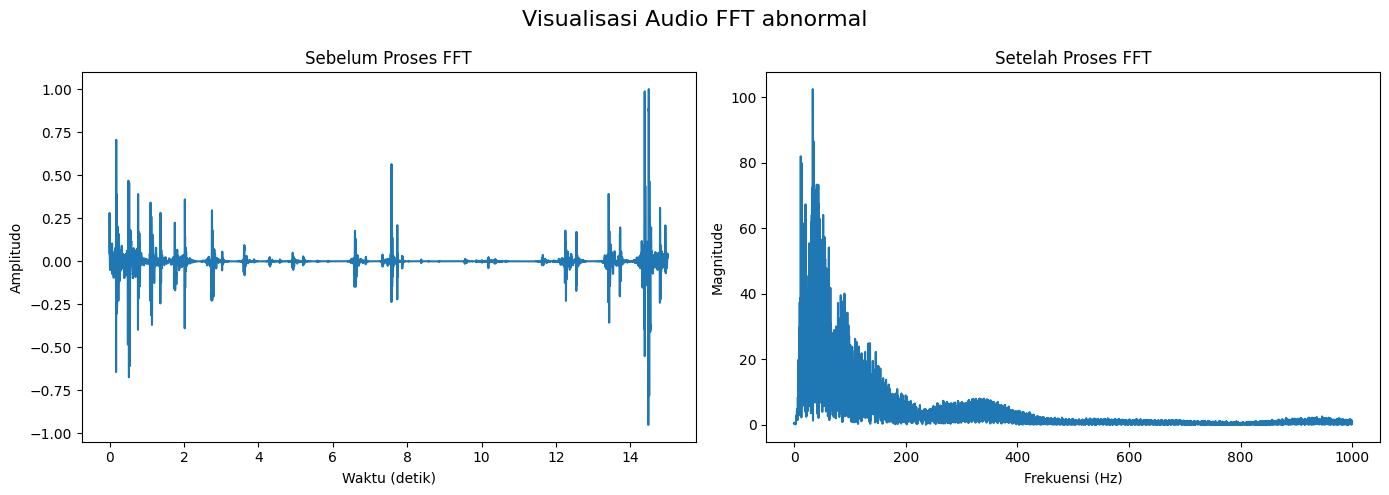

In [7]:
def visualize_fft_audio(input_folder, output_folder, label):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(f'Visualisasi Audio FFT {label}', fontsize=16)
    
    # Plot data sebelum proses FFT
    rate, data = wavfile.read(os.path.join(input_folder, label, os.listdir(os.path.join(input_folder, label))[0]))
    time = len(data) / rate  # Hitung durasi dalam detik
    time_axis = np.linspace(0, time, len(data))  # Buat sumbu x dalam detik
    axes[0].plot(time_axis, data)
    axes[0].set_title('Sebelum Proses FFT')
    axes[0].set_xlabel('Waktu (detik)')
    axes[0].set_ylabel('Amplitudo')

    # Plot data setelah proses FFT
    fft_output = np.load(os.path.join(output_folder, label, os.listdir(os.path.join(output_folder, label))[0]))
    magnitude_output = np.abs(fft_output)
    freq_axis_output = np.fft.fftfreq(len(magnitude_output), d=1/rate)
    axes[1].plot(freq_axis_output[:len(freq_axis_output)//2], magnitude_output[:len(freq_axis_output)//2])
    axes[1].set_title('Setelah Proses FFT')
    axes[1].set_xlabel('Frekuensi (Hz)')
    axes[1].set_ylabel('Magnitude')

    plt.tight_layout()
    plt.show()

input_folder = "./4_normalizedData"
output_folder = "./5_fftData"

for label in ['normal', 'abnormal']:
    visualize_fft_audio(input_folder, output_folder, label)

## Augmentasi Data

In [8]:
count_files('./5_fftData')

Jumlah file di folder 'abnormal': 1783
Jumlah file di folder 'normal': 491


In [3]:
def augment_data(input_folder, output_folder, target_count):
    for label in ['normal', 'abnormal']:
        label_folder_path = os.path.join(input_folder, label)
        output_label_folder_path = os.path.join(output_folder, label)
        
        # Pastikan folder output untuk label sudah ada
        if not os.path.exists(output_label_folder_path):
            os.makedirs(output_label_folder_path)
        
        # Hitung jumlah file yang sudah ada di folder output untuk label tersebut
        existing_count = len(os.listdir(output_label_folder_path))
        
        # Jumlah file yang perlu ditambahkan
        augment_count = target_count - existing_count  # Perbedaan antara target_count dan jumlah file yang sudah ada
        
        if augment_count > 0:
            for i in range(augment_count):
                # Pilih file secara acak dari folder label
                selected_file = random.choice(os.listdir(label_folder_path))
                source_file = os.path.join(label_folder_path, selected_file)
                target_file = os.path.join(output_label_folder_path, f"augmented_{existing_count + i + 1}.npy")
                # Salin file dengan nama unik
                shutil.copyfile(source_file, target_file)

# Misalkan folder input dan output Anda adalah sebagai berikut:
input_folder = "./5_fftData"
output_folder = "./readyToUsed"

# Jumlah file yang diinginkan di setiap label setelah augmentasi
target_count = 1000  # Anda ingin memiliki 1000 file di setiap label

# Membuat augmentasi data dengan jumlah file yang berbeda di setiap label
augment_data(input_folder, output_folder, target_count)
print('Proses Augmentasi Data Selesai.')

Proses Augmentasi Data Selesai.


In [4]:
count_files('./readyToUsed')

Jumlah file di folder 'abnormal': 1000
Jumlah file di folder 'normal': 1000
